# Calculus in Medical Data. Electrocardiography (EKG)
#### Yordan Penev

### Theory

The heart rate contains a lot of information about you. Apart from the obvious number of beats per minute there is information about your health, physical fitness and even mental activity in there. If you got yourself a heart rate sensor and some data, you could of course buy an analysis package or try some of the open source things available, but not all of them might do the things you want or need. 

Recent technological advances have made it possible to build wearable products that can capture and process bio-signals generated by the human body. When it comes to heart rate monitoring, two primary technologies are available to device manufacturers: ECG and PPG.

#### EКG & PPG Sensors Defined
- EКG (electrocardiography) sensors measure the bio-potential generated by electrical signals that control the expansion and contraction of heart chambers.
- PPG (photoplethysmography) sensors use a light-based technology to sense the rate of blood flow as controlled by the heart’s pumping action.

When it comes to key considerations like size, power consumption, accuracy, ease of integration and richness of data, EКG biosensors present a clear advantage over their PPG counterparts for heart rate monitoring.
EКG biosensors are capable of delivering the widest range of heart health metrics because they are able to capture more comprehensive signals of overall heart performance, including both Heart Rate (HR) and Heart Rate Variability (HRV).
In contrast, PPG sensors are capable only of measuring HR, and less reliably than with ECG biosensors. The key challenges with PPG technology are cancelling the effects of ambient light, accommodating different skin conditions and colors, and dealing with physical motion artifacts. Additionally, PPG can only be used on parts of the body that have a high concentration of blood vessels (for example, it can be difficult to get a good PPG signal from the wrist)

Some companies, like Samsung, use a PPG sensors on different devices to measure stress and blood oxygen levels.

<img src="samsung.jpg" alt="drawing" width="200"/>

#### Main parts of EКG
For this notebook there is no need a lot of theory. Just know that when talking about the shape of the heart rate signal, each beat is characterized by a QRS-complex as shown below in a.), I-III (Q-R-S). There is also a P-wave (IV), and a T-wave (V). The R component is the large peak (II). This is the one of interest to us:

<img src="ppg_ecg.jpg" alt="drawing"/>

In photoplethysmogram signals (PPG) the signal is slightly different. The PPG signal is shown in b.) of the image. Components here are the Diastolic peak (I), which is the point of highest blood pressure, and the Diastolic peak (III). The two waves are separated by what is called the Dicrotic Notch (II). In this case the Systolic Peak (I) is used for heart rate extraction.
For the development of a peak-detection algorithm this is a nice coincidence: for both signals we need to label the highest peak in each complex.


### Read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import math

      hart
0      530
1      518
2      506
3      494
4      483
...    ...
2478   489
2479   491
2480   492
2481   493
2482   494

[2483 rows x 1 columns]


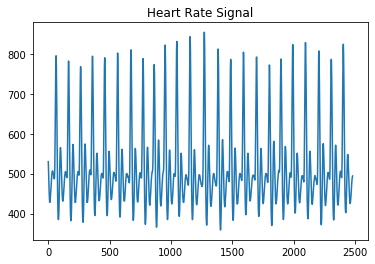

In [2]:
dataset = pd.read_csv("data.csv") #Read data from CSV datafile

print(dataset) # Dataset is one dementional array with 2483 elements

plt.title("Heart Rate Signal") #The title of our plot
plt.plot(dataset.hart) #Draw the plot object
plt.show() #Display the plot

### Detecting first peaks

The first step is to find the position of all the R-peaks. To do this we need to determine Regions of Interest (ROI’s), namely for each R-peak in the signal. After we have these, we need to determine their maxima. There are a few ways to go about doing this:

- Fit a curve on the ROI datapoints, solve for the x-position of the maximum;
- Determine the slope between each set of points in ROI, find the set where the slope reverses;
- Mark datapoints within ROI, find the position of the highest point.

The first provides an exact mathematical solution (more accurately: as exact as you want), but is also the most expensive computationally. With our example dataset the difference does not matter, but at the time I was developing this algorithm I had to go through almost half a billion datapoints quickly, and future datasets seemed only to get larger. Most of this code will also be re-written to C for use on an embedded ARM chip, so we need to keep it simple and efficient.
The latter two methods are computationally much less expensive, but also less precise. High precision with these methods relies much more strongly on a high sampling rate than it does with the curve fitting method. After all, the actual maximum of the curve will probably lie somewhere between two data points rather than on an actual data point, with a higher sampling rate this error margin will decrease.
Now to work: first separate the different peaks from one another. For this we draw a moving average, mark ROI’s where the heart rate signal lies above the moving average, and finally find the highest point in each ROI as such: 

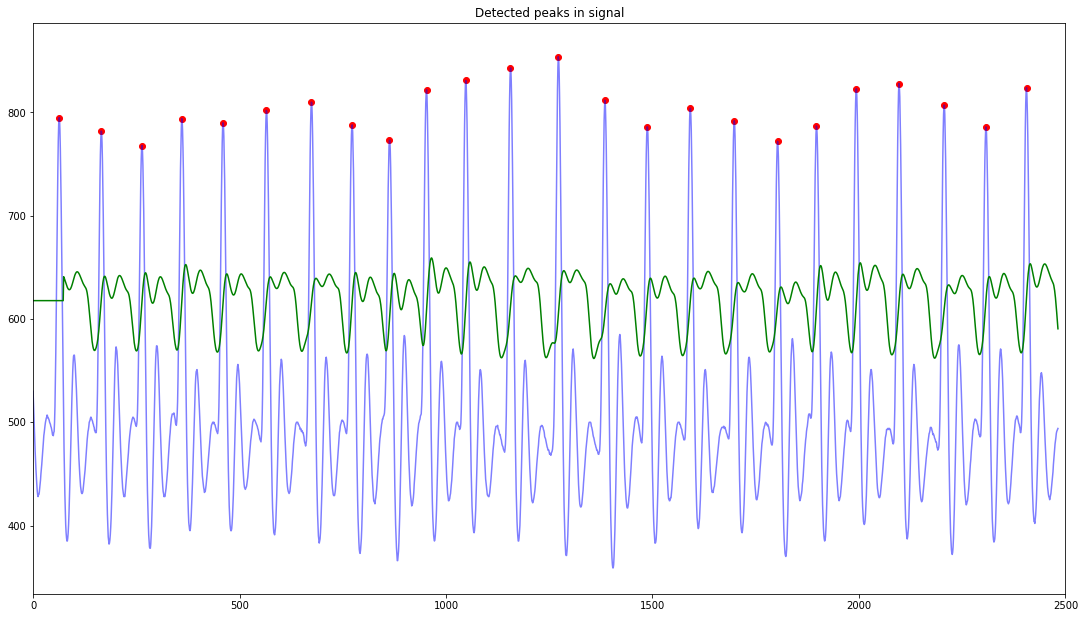

In [3]:
dataset = pd.read_csv("data.csv")

#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz

mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean() #Calculate moving average
#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.hart))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, later we will do this dynamically
dataset['hart_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns

for datapoint in dataset.hart:
    rollingmean = dataset.hart_rollingmean[listpos] #Get local mean
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1
    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.hart[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(dataset.hart, alpha=0.5, color='blue') #Plot semi-transparent HR
plt.plot(mov_avg, color ='green') #Plot moving average
plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
    
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

We have marked the highest point in each R-complex in our signal, not bad!
Some may ask: why the moving average, why not just use a horizontal line at around 700 as a threshold? This is a valid question and would work fine with this signal. Why we use a moving average has to do with less idealized signals. The amplitude of the R-peaks can change over time, especially when the sensor moves a bit. The amplitude of the smaller secondary peak can also change independently of the amplitude of the R-peak, sometimes having almost the same amplitude.

### Calculating heart rate


We know the position of each peak in time, so calculating the average ‘beats per minute’ (BPM) measure over this signal is straightforward. Just calculate the distance between the peaks, take the average and convert to a per minute value, like so:

In [4]:
RR_list = []
cnt = 0

while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print("Average Heart Beat is: %.01f" %bpm) #Round off to 1 decimal and print

Average Heart Beat is: 58.9


Also update the plot method to show the BPM in the legend:

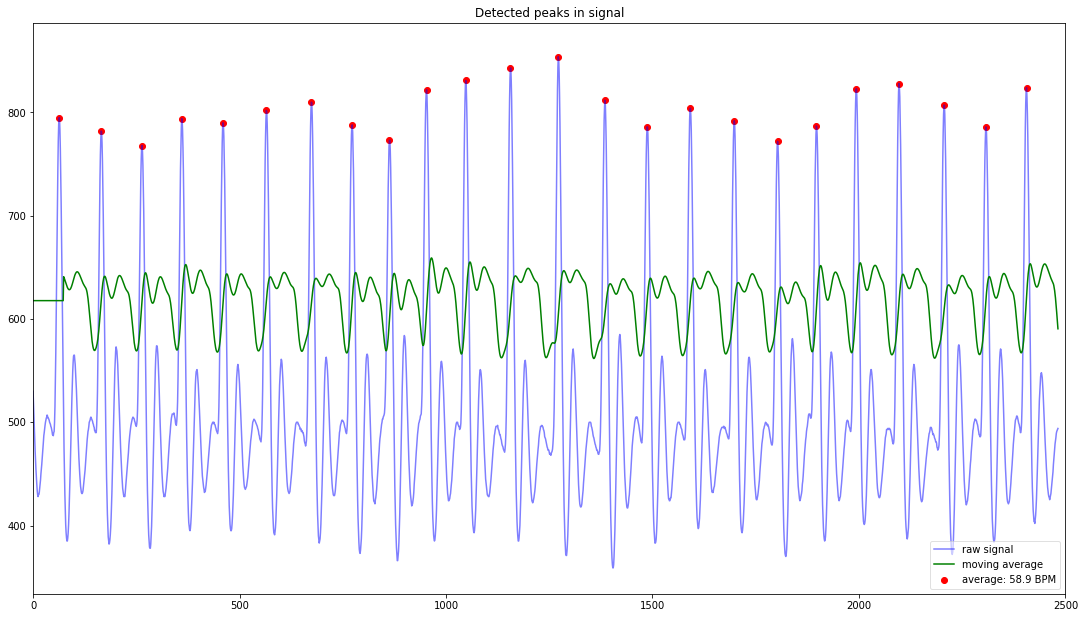

In [5]:
plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(dataset.hart, alpha=0.5, color='blue', label="raw signal") #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label="moving average") #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %bpm) #Plot detected peaks
plt.legend(loc=4, framealpha=0.6)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

Pretty cool! You have taken the first step in analyzing the heart rate signal. The number of beats per minute is a useful measure that is very often used in scientific studies and has many non-scientific uses as well, but the signal contains much, much more information.

### Rounding up

Finally let’s tidy up our code and put it in callable functions. This will make our life much easier in the next part, and our code much more organized and re-usable.

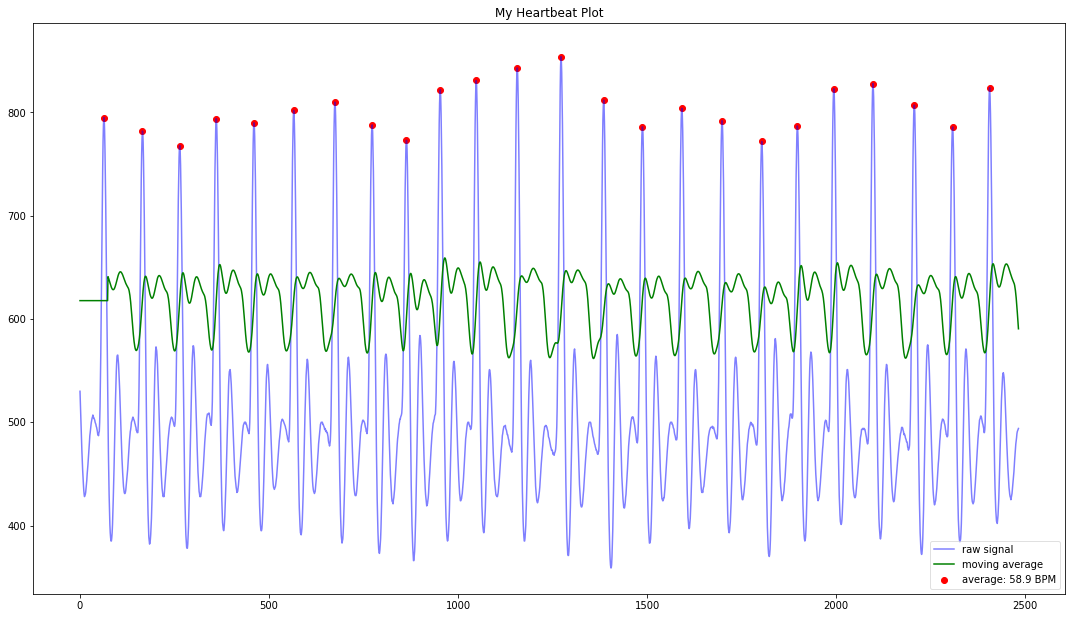

dict_keys(['peaklist', 'ybeat', 'RR_list', 'bpm'])


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

measures = {}

def get_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

def rolmean(dataset, hrw, fs, coef):
    mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean()
    avg_hr = (np.mean(dataset.hart))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*coef for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg

def detect_peaks(dataset):
    window = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.hart:
        rollingmean = dataset.hart_rollingmean[listpos]
        if (datapoint < rollingmean) and (len(window) < 1):
            listpos += 1
        elif (datapoint > rollingmean):
            window.append(datapoint)
            listpos += 1
        else:
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window)))
            peaklist.append(beatposition)
            window = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.hart[x] for x in peaklist]

def calc_RR(dataset, fs):
    RR_list = []
    peaklist = measures['peaklist']
    cnt = 0
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    measures['RR_list'] = RR_list

def calc_bpm():
    RR_list = measures['RR_list']
    measures['bpm'] = 60000 / np.mean(RR_list)

def plotter(dataset, title):
    peaklist = measures['peaklist']
    ybeat = measures['ybeat']
    plt.title(title)
    plt.plot(dataset.hart, alpha=0.5, color='blue', label="raw signal")
    plt.plot(dataset.hart_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

def process(dataset, hrw, fs, coef = 1.2): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean(dataset, hrw, fs, coef)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")
    

dataset = get_data("data.csv")

process(dataset, 0.75, 100)

#This object contains the dictionary 'measures' with all values in it
#Now we can also retrieve the BPM value (and later other values) like this:
bpm = measures['bpm']

#To view all objects in the dictionary, use "keys()" like so:
print(measures.keys())

# Extracting complex measures from the heart rate signal (HRV)
## Some Theory and Background

The heart rate signal contains a lot of information, not just about your heart but also about your breathing, short-term blood pressure regulation, body temperature regulation and hormonal blood pressure regulation (long term). It has also (though not always consistently) been linked to mental effort, and not surprisingly so since your brain is a very hungry organ, using up to 25% of your total glucose and 20% of your oxygen consumption. If its activity increases your heart needs to work harder to keep it supplied.
The measures we are interested in can be split into time-series data en frequency domain data. If you are familiar with fourier transforms the frequency part will make sense. If not, the [wikipedia page](https://en.wikipedia.org/wiki/Fourier_transform) has a good explanantion, and also a [very nice visualisation](https://en.wikipedia.org/wiki/Fourier_transform#/media/File:Fourier_transform_time_and_frequency_domains_%28small%29.gif) of the process. The basic idea is that you take a signal that repeats over time (such as the heart rate signal), and determine what frequencies make up the signal. You ‘transform the signal from the time domain to the frequency domain’. [Here is another visualisation](https://upload.wikimedia.org/wikipedia/commons/1/1a/Fourier_series_square_wave_circles_animation.gif), which clearly shows how a repeating signal can be approximated as the sum of different sine waves repeating over time.
Time Series Data
For the time-series portion of the heart rate signal we are mostly concerned with the intervals between the heart beats and how they vary over time. We want the position of all R-complexes (R1, R2,…Rn), the intervals between them (RR1, RR2,…RRn, defined as  ) and the differences between adjacent intervals (RRdiff-1,…RRdiff-n, defined as ).
 To visualize:

 <img src="intervals.jpg" alt="drawing"/>
 
 The **time series** measures often found in the scientific literature are:

- BPM, the amount of heart beats per minute, we calculated already;
- IBI (inter-beat interval), the mean distance of intervals between heartbeats, we implicitly calculated this already as part of the BPM calculation;
- SDNN, the standard deviation of intervals between heartbeats:  
$SDNN = \sqrt{ \frac{1}{N-1} \sum_{i=1}^{n} (RR_i - \overline{RR})^2}$


- SDSD, the standard deviation of successive differences between adjacent R-R intervals:  
$SDSD = \sqrt{ \frac{1}{N-1} \sum_{i=1}^{n} (RRdiff_i - \overline{RRdiff})^2}$


- RMSSD, the root mean square of successive differences between adjacent R-R intervals:  
$RMSSD = \sqrt{ \frac{1}{N-1} \sum_{i=1}^{n} (RRdiff_i)^2}$


- pNN50/pNN20, the proportion of differences greater than 50ms / 20ms.

The IBI, SDNN, SDSD, RMSSD en pNNx (and also frequency domain measures) are often grouped under **“Heart Rate Variability” (HRV) measures**, because they give information about how the heart rate varies over time.

##### Frequency Domain Data

On the frequency side of the heart rate signal the most often found measures are called the HF (High Frequency), MF (Mid Frequency) and LF (Low Frequency) bands, an eternal testament to the level of creative naming found in science. The MF en HF bands are often taken together and just labeled ‘HF’. LF and HF roughly correspond to 0.04-0.15Hz for the LF band and 0.16-0.5Hz for the HF band. The **LF** band seems related to short-term **blood pressure** variation, the **HF** band to breathing rate, **stress and oxygen level**.
The frequency spectrum is calculated performing a Fast Fourier Transform over the R-R interval dataseries. This method is, as the name implies, fast compared to the Discrete Fourier Transform method. The larger the dataset, the larger the speed difference between the methods.
We will calculate the measure for HF and LF by first to re-sampling the signal so we can estimate the spectrum, then transforming the re-sampled signal to the frequency domain, then integrating the area under the curve at the given intervals.


 

## Time Domain Measures – Getting Started
Looking at the above time-series measures, we need a few ingredients to easily calculate all of them:

A list of the positions of all R-peaks;
A list of the intervals between all subsequent R-R pairs (RR1, RR2,.. RR-n);
A list of the differences between all subsequent intervals between R-R pairs (RRdiff1,… RRdiffn);
A list of the squared differences between all subsequent differences between R-R pairs.
We already have the list of all R-peak positions from the detect_peaks() function, which is contained in dict[‘peaklist’]. We also have a list of R-R pair differences from the calc_RR() function, which is in dict[‘RR_list’]. Great! No additional code written, already 50% of the way there.
To get the final two ingredients we use dict[‘RR_list’] and calculate both the differences and the squared differences between adjacent values:


In [7]:
RR_diff = []
RR_sqdiff = []
RR_list = measures['RR_list']
cnt = 1 #Use counter to iterate over RR_list

while (cnt < (len(RR_list)-1)): #Keep going as long as there are R-R intervals
    RR_diff.append(abs(RR_list[cnt] - RR_list[cnt+1])) #Calculate absolute difference between successive R-R interval
    RR_sqdiff.append(math.pow(RR_list[cnt] - RR_list[cnt+1], 2)) #Calculate squared difference
    cnt += 1

print("RR diff:",RR_diff)
print("RR sqdiff:",RR_sqdiff)

RR diff: [30.0, 40.0, 50.0, 40.0, 100.0, 90.0, 0.0, 50.0, 130.0, 80.0, 30.0, 110.0, 30.0, 10.0, 10.0, 110.0, 30.0, 60.0, 60.0, 70.0, 40.0]
RR sqdiff: [900.0, 1600.0, 2500.0, 1600.0, 10000.0, 8100.0, 0.0, 2500.0, 16900.0, 6400.0, 900.0, 12100.0, 900.0, 100.0, 100.0, 12100.0, 900.0, 3600.0, 3600.0, 4900.0, 1600.0]


## Calculating Time Domain Measures
Now that the ingredients are there, it’s easy to calculate all measures:

In [8]:
ibi = np.mean(RR_list) #Take the mean of RR_list to get the mean Inter Beat Interval
print("IBI:", ibi)

sdnn = np.std(RR_list) #Take standard deviation of all R-R intervals
print("SDNN:", sdnn)

sdsd = np.std(RR_diff) #Take standard deviation of the differences between all subsequent R-R intervals
print("SDSD:", sdsd)

rmssd = np.sqrt(np.mean(RR_sqdiff)) #Take root of the mean of the list of squared differences
print("RMSSD:", rmssd)

nn20 = [x for x in RR_diff if (x>20)] #First create a list of all values over 20, 50
nn50 = [x for x in RR_diff if (x>50)]
pnn20 = float(len(nn20)) / float(len(RR_diff)) #Calculate the proportion of NN20, NN50 intervals to all intervals
pnn50 = float(len(nn50)) / float(len(RR_diff)) #Note the use of float(), because we don't want Python to think we want an int() and round the proportion to 0 or 1
print("pNN20, pNN50:", pnn20, pnn50)

IBI: 1018.695652173913
SDNN: 65.76006108019
SDSD: 35.26382586966403
RMSSD: 65.93647736738025
pNN20, pNN50: 0.8571428571428571 0.42857142857142855


That’s it for the **time series** measures. Let’s wrap them up in callable functions. We expand the calc_RR() function to calculate our extra ingredients and append them to the dictionary object, and also merge calc_bpm() with the other time series measurements into a new function calc_ts_measures() and append them to the dictionary:

In [9]:
def calc_RR(dataset, fs):
    peaklist = measures['peaklist']
    RR_list = []
    cnt = 0
    
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    RR_diff = []
    RR_sqdiff = []
    cnt = 0
    
    while (cnt < (len(RR_list)-1)):
        RR_diff.append(abs(RR_list[cnt] - RR_list[cnt+1]))
        RR_sqdiff.append(math.pow(RR_list[cnt] - RR_list[cnt+1], 2))
        cnt += 1
    
    measures['RR_list'] = RR_list
    measures['RR_diff'] = RR_diff
    measures['RR_sqdiff'] = RR_sqdiff

def calc_ts_measures():
    RR_list = measures['RR_list']
    RR_diff = measures['RR_diff']
    RR_sqdiff = measures['RR_sqdiff']
    
    measures['bpm'] = 60000 / np.mean(RR_list)
    measures['ibi'] = np.mean(RR_list)
    measures['sdnn'] = np.std(RR_list)
    measures['sdsd'] = np.std(RR_diff)
    measures['rmssd'] = np.sqrt(np.mean(RR_sqdiff))
    NN20 = [x for x in RR_diff if (x>20)]
    NN50 = [x for x in RR_diff if (x>50)]
    measures['nn20'] = NN20
    measures['nn50'] = NN50
    measures['pnn20'] = float(len(NN20)) / float(len(RR_diff))
    measures['pnn50'] = float(len(NN50)) / float(len(RR_diff))

#Don't forget to update our process() wrapper to include the new function
def process(dataset, hrw, fs, coef = 1.2):
    rolmean(dataset, hrw, fs, coef)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_ts_measures()
    plotter(dataset, "My Heartbeat Plot")

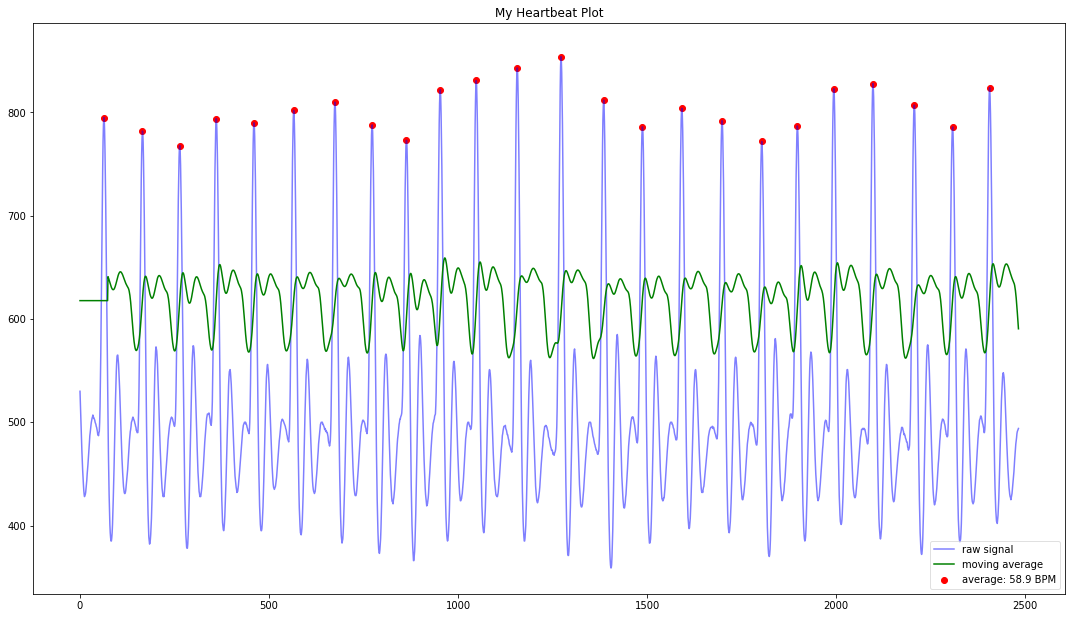

BPM:  58.898847631242
IBI:  1018.695652173913
SDNN:  65.76006108019
dict_keys(['peaklist', 'ybeat', 'RR_list', 'bpm', 'RR_diff', 'RR_sqdiff', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'nn20', 'nn50', 'pnn20', 'pnn50'])


In [10]:
dataset = get_data('data.csv')

process(dataset, 0.75, 100)
#The module dict now contains all the variables computed over our signal:
print("BPM: ", measures['bpm'])
print("IBI: ", measures['ibi'])
print("SDNN: ", measures['sdnn'])
#etcetera
#Remember that you can get a list of all dictionary entries with "keys()":
print(measures.keys())

## Frequency Domain Measures – Getting Started
The calculation of the frequency domain measures is a bit more tricky. The main reason is that we do not want to transform the heart rate signal to the frequency domain (doing so would only return a strong frequency equal to BPM/60, the heart beat expressed in Hz). Rather, we want to transform the R-R intervals to the frequency domain. Difficult to understand? Think about it like this: your heart rate varies over time as your heart speeds up and slows down in response to the changing demands of your body. This variation is expressed in the changing distances between heart beats over time (the R-R intervals we calculated earlier). The distances between R-R peaks vary over time with their own frequency. To visualize, plot the R-R intervals we calculated earlier:

![Alt text](Pt2_RR_List.jpeg)


From the plot you can clearly see that the R-R intervals do not change abrubtly per heart beat, but vary over time in a sine-wave like pattern (more precisely: a combination of different sine waves). We want to find the frequencies that make up this pattern.
However, any fourier transform method depends on evenly spaced data, and our R-R intervals are most certainly not evenly spaced in time. This is because the position in time of the intervals is dependent on their length, which is different for each interval. I hope this makes sense.
To find our measures, we need to:

Create an evenly spaced timeline with the R-R intervals on it;
Interpolate the signal, which serves to both create an evenly spaced time-series and increase the resolution;
This interpolation step is also called re-sampling in some studies.
Transform the signal to the frequency domain;
Integrate the area under the LF and HF portion of the spectrum.

### Calculating Frequency Domain Measures
First we create an evenly spaced timeline for the R-R intervals. To do this we take the sample position of all R-peaks, which is housed in the list dict[‘peaklist’] that we calculated already. We then assign the y-values to these sample positions from the list dict[‘RR_list’], which contains the duration of all R-R intervals. Finally we interpolate the signal.


In [11]:
from scipy.interpolate import interp1d #Import the interpolate function from SciPy

peaklist = measures['peaklist'] #First retrieve the lists we need

RR_list = measures['RR_list']
RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

Note that the **time series** does not start at the first peak, but at the sample position of the second R-peak. Because we work with the intervals, the first interval is available at the second peak.
We can now use the created function f() to find the y value of any x-position within our signal range:

In [12]:
print(f(250))
#Returns 996.94, the Y value at x=250

996.9413687714588


Simlarly, we can pass our entire timeseries RR_x_new to the function and plot it:
p

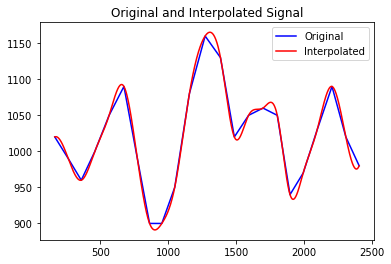

In [13]:
plt.title("Original and Interpolated Signal")
plt.plot(RR_x, RR_y, label="Original", color='blue')
plt.plot(RR_x_new, f(RR_x_new), label="Interpolated", color='red')
plt.legend()
plt.show()

Now to find the frequencies that make up the interpolated signal, use numpy’s fast fourier transform np.fft.fft() method, calculate sample spacing, convert sample bins to Hz and plot:

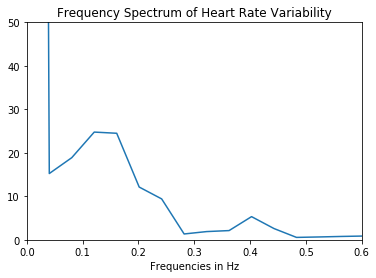

In [14]:
#Set variables
n = len(dataset.hart) #Length of the signal
frq = np.fft.fftfreq(len(dataset.hart), d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(n//2)] #Get single side of the frequency range

#Do FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(n//2)] #Return one side of the FFT

#Plot
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0,0.6) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequencies in Hz")
plt.show()

Nice! You can clearly see the LF and HF frequency peaks in the signal.
The last thing remaining is to integrate the area under curve at the LF (0.04 – 0.15Hz) and HF (0.16 – 0.5Hz) frequency bands. We need to find the data points corresponding to the frequency range we’re interested in. During the FFT we calculated the one-sided frequency range frq, so we can search this for the required data point positions.

In [15]:
lf = np.trapz(abs(Y[(frq>=0.04) & (frq<=0.15)])) #Slice frequency spectrum where x is between 0.04 and 0.15Hz (LF), and use NumPy's trapezoidal integration function to find the area
print("LF:", lf)

hf = np.trapz(abs(Y[(frq>=0.16) & (frq<=0.5)])) #Do the same for 0.16-0.5Hz (HF)
print("HF:", hf)

LF: 38.889763602405644
HF: 47.31778222338868


These are the areas under the frequency plot at the frequency spectra of interest.

**Remember from the theory that HF is related to stress and oxygen level and LF to short-term blood pressure regulation.** 


# Conclusion

**Many diseases can be diagnosed from EKG data.**  
A reduction of **HRV** has been reported in several cardiovascular (Myocardial infarction,Diabetic neuropathy,Cardiac transplantation,Myocardial dysfunction - Heart Failure) and noncardiovascular diseases (Tetraplegia,Sepsis,Liver cirrhosis).

Initially, the focus of HRV investigation was its use in the prediction of long-term survival in patients who had suffered myocardial infarction, or had valvular or congestive heart disease.  More recently, work has concentrated on attempts to predict the timing of onset of fatal ventricular tachyarrhythmias (VTAs). While the prognostic value of HRV post-myocardial infarction is well established, evidence of value in VTAs and sudden death is less clear. It is not yet possible to predict the onset of ventricular arrhythmias using HRV techniques, there is now the best predictors of VTAs include TWA, HRT, QRS duration, fragmented QRS, and QRS-T angle parameters. As shown by many studies, autonomic dysfunction may be a less important or variable factor in the pathophysiology of ventricular arrhythmias  in noncoronary disease, therein TWA was the most sensitive predictor. In contrast, HRV,HRT, and BRS were not statistically signiﬁcant predictors.Some studies show that reduced HRV is predictive for obstructive coronary artery disease  independent of traditional risk factors and Framingham risk.

*For more information:*  
[HRVcanPredictCAD.pdf](https://www.researchgate.net/profile/Tatiyana_Vaikhanskaya2/post/what_are_the_diseases_that_can_be_detected_by_heart_rate_variability/attachment/59d6360c79197b80779937db/AS%3A386669971820546%401469200713663/download/5_minHRVcanPredictCAD.pdf)  
[GoldbergRiskStatifNonInvas.pdf](https://www.researchgate.net/profile/Tatiyana_Vaikhanskaya2/post/what_are_the_diseases_that_can_be_detected_by_heart_rate_variability/attachment/59d6360c79197b80779937d9/AS%3A386669971820544%401469200713033/download/GoldbergRiskStatifNonInvas.pdf)  
[MainPredictSCD2016.pdf](https://www.researchgate.net/profile/Tatiyana_Vaikhanskaya2/post/what_are_the_diseases_that_can_be_detected_by_heart_rate_variability/attachment/59d6360c79197b80779937d8/AS%3A386669967626241%401469200712952/download/MainPredictSCD2016.pdf)  
[HRVadditiveValue2016.pdf](https://www.researchgate.net/profile/Tatiyana_Vaikhanskaya2/post/what_are_the_diseases_that_can_be_detected_by_heart_rate_variability/attachment/59d6360c79197b80779937da/AS%3A386669971820545%401469200713110/download/HRVadditiveValue2016.pdf)


## Test with other data set

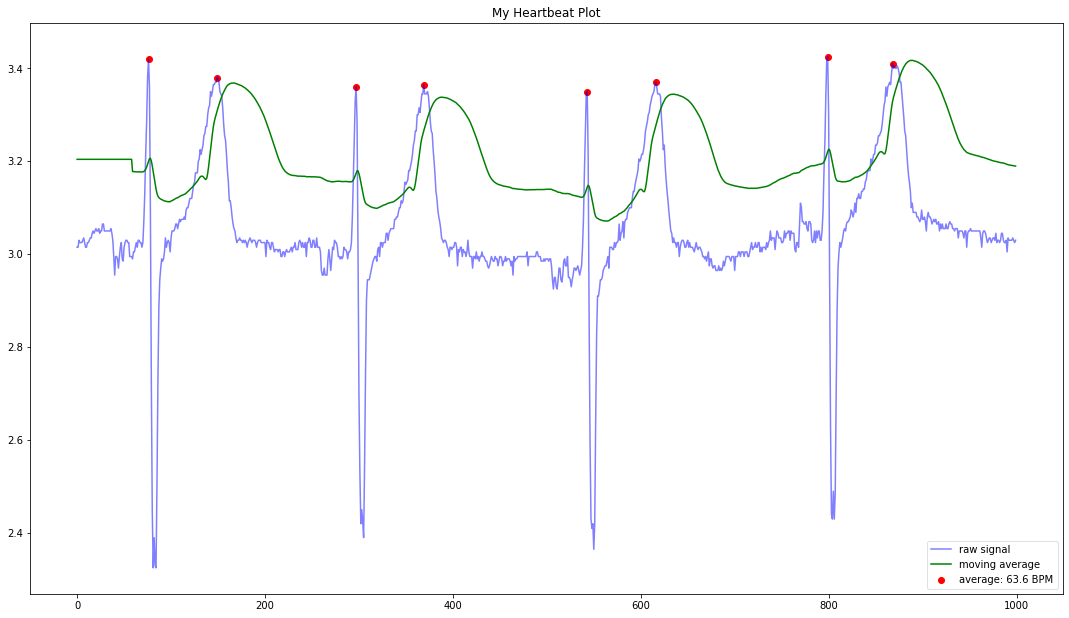

BPM:  63.63636363636363
IBI:  942.8571428571429
SDNN:  406.5785563073631
SDSD:  128.25995978461322
RMSSD:  812.9592719059042


In [16]:
dataset = get_data("e01102.csv")

process(dataset, 0.5, 120, 1.05)

print("BPM: ", measures['bpm'])
print("IBI: ", measures['ibi'])
print("SDNN: ", measures['sdnn'])
print("SDSD: ", measures['sdsd'])
print("RMSSD: ", measures['rmssd'])


# Bibliography

1. van Gent, P. (2016). Analyzing a Discrete Heart Rate Signal Using Python. A tech blog about fun things with Python and embedded electronics. Retrieved from: http://www.paulvangent.com/2016/03/15/analyzing-a-discrete-heart-rate-signal-using-python-part-1/
2. ECG vs PPG for Heart Rate Monitoring: Which is Best? Retrieved from: http://neurosky.com/2015/01/ecg-vs-ppg-for-heart-rate-monitoring-which-is-best/
3. ECG vs EKG: What’s the Difference? Retrieved from: http://neurosky.com/2015/05/ecg-vs-ekg-whats-the-difference/
4. Electrocardiography. Retrieved from: https://en.wikipedia.org/wiki/Electrocardiography
5. Photoplethysmogram. Retrieved from: https://en.wikipedia.org/wiki/Photoplethysmogram
6. Samsung heart rate sensors. Retrieved from: https://www.samsung.com/us/heartratesensor/
7. Researchgate - Diseases that can be detected by heart rate variability .Retrieved from: https://www.researchgate.net/post/what_are_the_diseases_that_can_be_detected_by_heart_rate_variability
